# BADVFL

In [466]:
# Importing essential libraries and modules for deep learning and visualization
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset

from sklearn.metrics import classification_report, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}.")

Running on cuda.


In [3]:
# Fashion_MNIST
fashion_labels = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

In [66]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.FashionMNIST(root='../data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='../data', train=False, download=True, transform=transform)
print("Train",trainset.data.shape,trainset.targets.shape)
print("Train",testset.data.shape,testset.targets.shape)

# Split of a little bit from the training data as the auxiliary dataset

aux_dataset_size = 100

auxset,trainset = torch.utils.data.random_split(trainset,(aux_dataset_size,len(trainset)-aux_dataset_size))

print("Trainset:",len(trainset))
print("Testset:",len(testset))
print("Auxset:",len(auxset))

Train torch.Size([60000, 28, 28]) torch.Size([60000])
Train torch.Size([10000, 28, 28]) torch.Size([10000])
Trainset: 59900
Testset: 10000
Auxset: 100


In [354]:
def split_data(dataset,K,axis):
    data = [ [] for _ in range(K) ]
    labels = [ [] for _ in range(K)]
    for i in range(len(dataset)):
        image,label = dataset[i]
        image = image[0]
        #print(image.shape)
        splits = torch.tensor_split(image,K,dim=axis)
        for i,s in enumerate(splits):
            data[i].append(s)
            labels[i].append(label)
        
    X = [
        torch.as_tensor(np.array(x)) for x in data
    ]
    Y = [
        torch.as_tensor(np.array(y)) for y in labels
    ]
    datasets = [
        TensorDataset(x,y) for x,y in zip(X,Y)
    ]
    return datasets
    
        
    


In [355]:
train_datasets = split_data(trainset,num_clients,1)


In [368]:
import random
def test(K,axis):
    datasets = split_data(trainset,K,axis)
    rand_idx = random.randrange(0,len(datasets[0]))
    print("#Datasets:",len(datasets))
    images = [
        datasets[i][rand_idx][0] for i in range(K)
    ]
    print(fashion_labels[datasets[0][rand_idx][1]])

    for im in images:
        print(im.shape,end=",")
        plt.imshow(im, cmap="gray")
        plt.show()
    if axis == 1:
        full_image = torch.hstack(images)
    elif axis == 0:
        full_image = torch.vstack(images)
    print("Full image shape:",full_image.shape)


    plt.imshow(full_image, cmap="gray")
    plt.show()

#Datasets: 4
Dress
torch.Size([7, 28]),

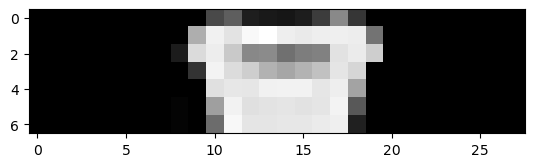

torch.Size([7, 28]),

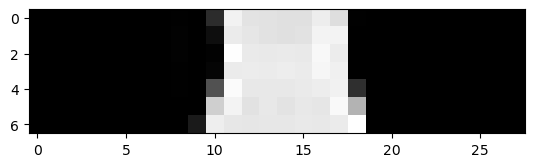

torch.Size([7, 28]),

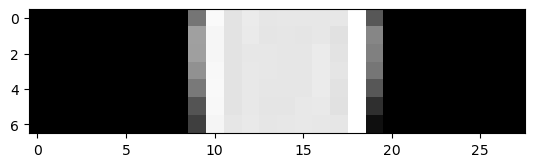

torch.Size([7, 28]),

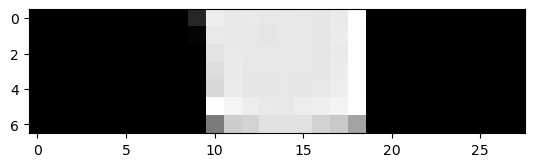

Full image shape: torch.Size([28, 28])


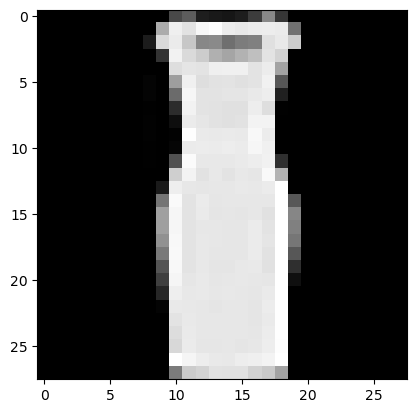

In [369]:
test(4,0)

#Datasets: 3
T-shirt/top
torch.Size([28, 10]),

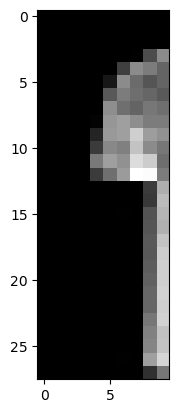

torch.Size([28, 9]),

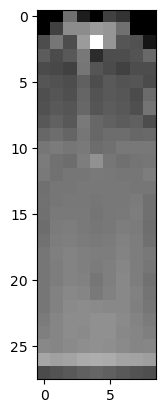

torch.Size([28, 9]),

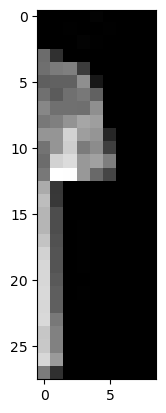

Full image shape: torch.Size([28, 28])


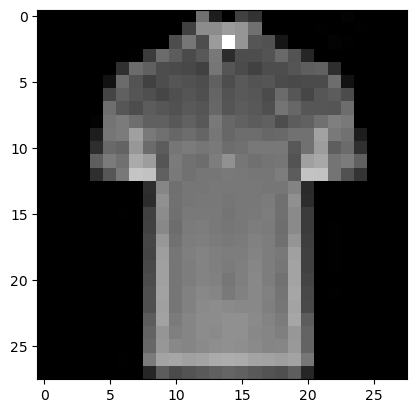

In [370]:
test(3,1)

## Setup VFL

In [437]:
class Client():
    def __init__(self,traindata,testdata,model):
        self.training_data = traindata
        self.test_data = testdata
        self.model = model
        self.optimizer = torch.optim.Adam(self.model.parameters(),lr=0.001)
        
    def forward_pass(self,indices, train = True):
        if train:
            data = self.training_data[indices][0]
            self.model.train()
        else:
            data = self.test_data[indices][0]
            self.model.eval()
        data = data.unsqueeze(1)
        data = data.to(device)

        return self.model(data)

    def zero_grad(self):
        self.optimizer.zero_grad()
    
    def __repr__(self):
        return f"Client with {len(self.training_data)} training images and {len(self.test_data)} test images of shape {self.training_data[0][0].shape}"

In [488]:
class Server():
    def __init__(self,trainlabels,testlabels,model, clients,train_batch_size = 64, test_batch_size = 64):
        self.trainlabels = trainlabels
        self.testlabels = testlabels
        self.model = model
        self.train_batch_size = train_batch_size
        self.test_batch_size = test_batch_size
        self.clients = clients
        self.optimizer = torch.optim.Adam(self.model.parameters(),lr=0.001)
        self.loss_function = nn.CrossEntropyLoss()
        
    def forward(self,indices, train=True):
        embeddings = [
            c.forward_pass(indices,train=train) for c in clients
        ]
        concat = torch.hstack(embeddings) # Concat feature vectors that are the output from the clients

        return self.model(concat)

    def train_epoch(self,):
        self.model.train()
        dataset_size = self.trainlabels.size()[0]
        permutation = torch.randperm(dataset_size)
        for i in range(0,dataset_size,self.train_batch_size):
            self.optimizer.zero_grad()
            for c in clients:
                c.zero_grad()
            indices = permutation[i:i+self.train_batch_size]
            correct_labels = self.trainlabels[indices].to(device)
            prediction = self.forward(indices,train=True)
            loss = self.loss_function(prediction,correct_labels)
            loss.backward()
            self.optimizer.step()
            for c in clients:
                c.optimizer.step()
    def eval(self):
        # Lists to store all predictions and true labels
        all_preds = []
        all_labels = []
        dataset_size = self.testlabels.size()[0]
        self.model.eval()
        permutation = range(0,dataset_size)
        for i in range(0,dataset_size,self.test_batch_size):
            indices = permutation[i:i+self.train_batch_size]
            correct_labels = self.testlabels[indices]
            outputs = self.forward(indices,train=False)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(correct_labels.cpu().numpy())
        print(classification_report(all_labels, all_preds, target_names=fashion_labels))
        
    def __repr__(self):
        return f"Server with {len(self.trainlabels)} training labels and {len(self.testlabels)} test labels and {len(self.clients)} clients."

In [489]:


with torch.no_grad():
    # Iterate over all batches in the test loader
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        
        # Pass the images through the model to get predictions
        outputs = model(images)
        
        # Get the class with the maximum probability as the predicted class
        _, predicted = torch.max(outputs, 1)
        
        # Extend the all_preds list with predictions from this batch
        all_preds.extend(predicted.cpu().numpy())
        
        # Extend the all_labels list with true labels from this batch
        all_labels.extend(labels.cpu().numpy())

# Print a classification report which provides an overview of the model's performance for each class
print(classification_report(all_labels, all_preds, target_names=fashion_labels))

NameError: name 'testloader' is not defined

In [490]:
class ClientModel(nn.Module):
    def __init__(self):
        super(ClientModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3) 
        self.conv2 = nn.Conv2d(32, 64, 3)

        self.fc1 = nn.Linear(640, 128) 

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 640)
        x = F.relu(self.fc1(x))
        return x
    

In [491]:
class GlobalModel(nn.Module):
    def __init__(self,num_clients):
        super(GlobalModel, self).__init__()
        self.fc1 = nn.Linear(num_clients * 128, 128)  # Client model has 128 output features, 128*#clients must match the input for the global model
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x)) 
        x = self.fc3(x)

        return F.log_softmax(x, dim=1)

In [492]:
num_clients = 2
train_datasets = split_data(trainset,num_clients,0)
test_datasets = split_data(testset,num_clients,0)

In [493]:
ds = train_datasets[0]

In [494]:
clients = [
    Client(train,test,ClientModel().to(device)) for train,test in zip(train_datasets,test_datasets)
]
for c in clients:
    print(c)
server = Server(train_datasets[0][:][1],test_datasets[0][:][1],GlobalModel(len(clients)).to(device), clients)
print(server)

Client with 59900 training images and 10000 test images of shape torch.Size([14, 28])
Client with 59900 training images and 10000 test images of shape torch.Size([14, 28])
Server with 59900 training labels and 10000 test labels and 2 clients.


In [495]:
epochs = 5
for i in range(epochs):
    server.train_epoch()

In [496]:
server.eval()

              precision    recall  f1-score   support

 T-shirt/top       0.89      0.79      0.84      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.77      0.92      0.83      1000
       Dress       0.89      0.93      0.91      1000
        Coat       0.88      0.74      0.81      1000
      Sandal       0.99      0.97      0.98      1000
       Shirt       0.69      0.73      0.71      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.97      0.96      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

